<a href="https://colab.research.google.com/github/Gr3gP/Misc-Projects/blob/main/JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploring JAX

- https://blog.evjang.com/2019/02/maml-jax.html



##Gradients in JAX

In [1]:
!git clone https://github.com/ericjang/maml-jax.git
!cd maml-jax
!pip install -r requirements.txt

fatal: destination path 'maml-jax' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
!git clone https://github.com/google/jax
!cd jax
!python build/build.py # optionally add --enable_cuda 
!pip install -e build  # install jaxlib (includes XLA)
!pip install -e .      # install jax

fatal: destination path 'jax' already exists and is not an empty directory.
python3: can't open file 'build/build.py': [Errno 2] No such file or directory
ERROR: build is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with svn+, git+, hg+, or bzr+).
ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content


In [3]:
import jax.numpy as np
from jax import grad

In [4]:
#Gradient operator grad tranforms a pyhton function into another funtion 
#that computes the gradients. Here we will compute first, second, and third 
#order derivaties of e**x and x**2

f = lambda x : np.exp(x)
g = lambda x : np.square(x)
print(grad(f)(1.)) # = e^{1}
print(grad(grad(f))(1.))
print(grad(grad(grad(f)))(1.))

print(grad(g)(2.)) # 2x = 4
print(grad(grad(g))(2.)) # x = 2
print(grad(grad(grad(g)))(2.)) # x = 0

2.7182817
2.7182817
2.7182817
4.0
2.0
0.0


##Auto-vectorization with vmap

JAX makes it easy to set up NN. Below we will train a model to learn a function; fθ(x)=sin(x)

In [5]:
from jax import vmap #auto-vetorize functions
from functools import partial #use with vmap
from jax import jit #compiling functions speed-up
from jax import random #to initialize params
from jax.experimental import stax #nn library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax #nn layers
import matplotlib.pyplot as plt

We’ll define a simple neural network with 2 hidden layers. We’ve specified an in_shape of (-1, 1), which means that the model takes in a variable-size batch dimension, and has a feature dimension of 1 scalar (since this is a 1-D regression task). JAX’s helper libraries all take on a functional API (unlike TensorFlow, which maintains a graph state), so we get back a function that initializes parameters and a function that applies the forward pass of the network. These callables return lists and tuples of numpy arrays - a simple and flat data structure for storing network parameters.

In [6]:
#we will build a nn with 2 hiddne layers 
#use stax to initialize and eval functions
net_init, net_apply = stax.serial(
    Dense(30), Relu,
    Dense(30), Relu,
    Dense(1)
)
in_shape = (-1, 1,)
rng = random.PRNGKey(0)
out_shape, net_params = net_init(rng, in_shape)

In [7]:
#define model loss as MSE
def loss(params, inputs, targets):
    #computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

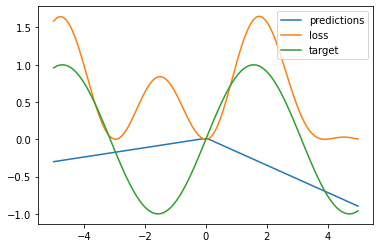

In [8]:
#batch the inference across K=100
xrange_inputs = np.linspace(-5,5,100).reshape((100,1)) #(k, 1)
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params)) (xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets)
plt.plot(xrange_inputs, predictions, label='predictions')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

For random initialization, the preds(blue) are way off from the target(green). Next we will train the network using gradient descent. We will use numpy's randomnum generator to initialize network params. 

In [9]:
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap #element wise manipulation of collections 

In [10]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)
#define a compiled update step
@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(loss) (p, x1, y1)
    return opt_update(i, g, opt_state)

for i in range(100):
    opt_state = step(i, opt_state, xrange_inputs, targets)
net_params = get_params(opt_state)

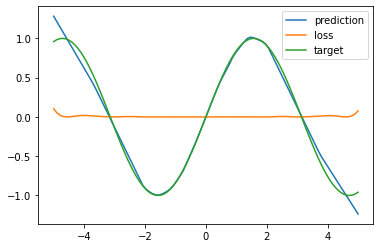

In [11]:
#batch inference across k=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) #per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

Looking at the network again after apply SGD, we can see the model very closely approximated the sinusoid curve. 

Next we will unit-test MAML on an objective g.

##MAML:Optimizing for generalization

In [12]:
#grad of grad test
#cehck numerics
g = lambda x, y: np.square(x) + y
x0 = 2.
y0 = 1.
print('grad(g)(x0) = {}'.format(grad(g)(x0, y0))) #2x = 4
print('0x - grad(g)(x0) = {}'.format(x0 - grad(g)(x0, y0))) # x - 2x = -2

def maml_objective(x,y):
    return g(x - grad(g)(x, y), y)
print('maml_objective(x,y) = {}'.format(maml_objective(x0, y0))) #x**2 + 1 = 5
print('x0 - maml_objective(x,y) = {}'.format(x0 - grad(maml_objective)(x0, y0))) #x - (2x)

grad(g)(x0) = 4.0
0x - grad(g)(x0) = -2.0
maml_objective(x,y) = 5.0
x0 - maml_objective(x,y) = -2.0


In [13]:
#graients of gradients test 
g = lambda x, y: np.square(x) + y
x0 = 2.
y0 = 1.
print('grad(g) (x0) = {}'.format(grad(g)(x0, y0))) #2x = 4
print('x0 - grad(g)(x0) = {}'.format(x0 - grad(g)(x0, y0))) # x - 2x = -2
def maml_objective(x,y):
    return g(x- grad(g)(x,y), y)
print('maml_onjective(x,y)= {}'.format(maml_objective(x0, y0))) #x**2 + 1 = 5
print('x0 = maml_objective(x,y) = {}'.format(x0 - grad(maml_objective)(x0, y0)))
#x - (2x) = -2

grad(g) (x0) = 4.0
x0 - grad(g)(x0) = -2.0
maml_onjective(x,y)= 5.0
x0 = maml_objective(x,y) = -2.0


##Sinusoid Task + MAML

In [14]:
alpha = .1
def inner_update(p, x1, y1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, x2)
    return loss(p2, x2, y2)

In [15]:
x1 = xrange_inputs
y1 = targets
x2 = np.array([0.])
y2 = np.array([0.])
maml_loss(net_params, x1, y1, x2, y2)

DeviceArray(0.00054016, dtype=float32)

In [16]:
#try and mimimize the MAML loss
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
#this lr seems better than 1e-2 and 1e-4
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(maml_loss)(p, x1, y1, x2, y2)
    l = maml_loss(p, x1, y1, x2,y2)
    return opt_update(i, g, opt_state), l
K=20

np_maml_loss = []

#adam optimizer
for i in range(20000):
    #define the task
    A = onp.random.uniform(low=0.1, high=.5)
    phase = onp.random.uniform(low=0., high=np.pi)
    #meta-training inner split (k examples)
    x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
    y1 = A * onp.sin(x1 + phase)
    #meta_training outer split (1 example). Like cross-validating with respect
    #to one example
    x2 = onp.random.uniform(low=5., high=5.)
    y2 = A * onp.sin(x2 + phase)
    opt_state, l = step(i, opt_state, x1, y1, x2, y2)
    np_maml_loss.append(l)
    if i % 1000 == 0:
        print(i)
net_params = get_params(opt_state)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


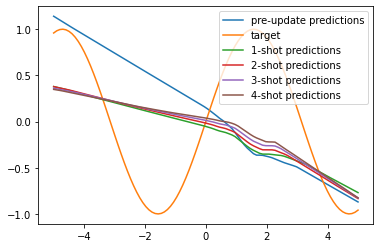

In [17]:
#batch inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1, 5):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
    plt.legend()

In [18]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

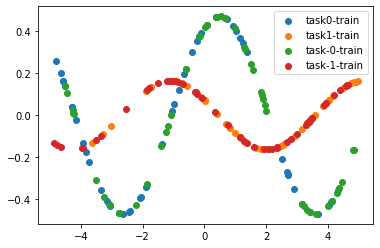

In [19]:
outer_batch_size = 2
x1, y1, x2, y2 = sample_tasks(outer_batch_size, 50)
for i in range(outer_batch_size):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(outer_batch_size):
    plt.scatter(x2[i], y2[i], label='task-{}-train'.format(i))
plt.legend()

In [20]:
x2.shape

(2, 50, 1)

In [21]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

#vmapped version of maml
#returns scaler for all tasks
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), 1

np_batched_maml_loss = []
K=20
for i in range(20000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    if i % 1000 == 0:
        print(i)
net_params = get_params(opt_state)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


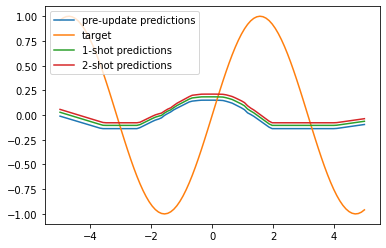

In [22]:
# batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(10,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,3):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

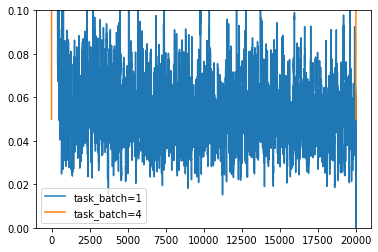

In [23]:
# Comparison of maml_loss for task batch size = 1 vs. task batch size = 8
plt.plot(onp.convolve(np_maml_loss, [.05]*20), label='task_batch=1')
plt.plot(onp.convolve(np_batched_maml_loss, [.05]*20), label='task_batch=4')
plt.ylim(0., 1e-1)
plt.legend()